<a href="https://colab.research.google.com/github/s4kh4rov/BMIL/blob/master/lab2rpsmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install pandas

In [14]:
import opendatasets as od
import pandas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout , BatchNormalization
import pandas as pd


In [4]:
od.download("https://www.kaggle.com/datasets/ashishmotwani/tomato/data?select=train")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexsakharov
Your Kaggle Key: ··········


100%|██████████| 1.37G/1.37G [00:27<00:00, 53.8MB/s]


In [51]:
from pathlib import Path
import imghdr
import os

# data_dir = "/content/tomato/train/Early_blight/"
# data_dir = "/content/tomato/train/Leaf_Mold/"
# data_dir = "/content/tomato/train/Septoria_leaf_spot/"
# data_dir = "/content/tomato/train/healthy/"
# data_dir = "/content/tomato/valid/Septoria_leaf_spot/"
# data_dir = "/content/tomato/valid/healthy/"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [63]:
train_datadir = '/content/tomato/train/'
valid_datadir = '/content/tomato/valid/'
IMG_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_datadir,
  color_mode='rgb',
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=15)

val_ds = tf.keras.utils.image_dataset_from_directory(
  valid_datadir,
  validation_split=0.3,
  subset="validation",
  color_mode='rgb',
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=15)

test_ds = tf.keras.utils.image_dataset_from_directory(
  valid_datadir,
  validation_split=0.3,
  subset="training",
  color_mode='rgb',
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=15)

Found 25838 files belonging to 11 classes.
Found 6678 files belonging to 11 classes.
Using 2003 files for validation.
Found 6678 files belonging to 11 classes.
Using 4675 files for training.


In [64]:
class_names = test_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

## Первая модель

In [65]:
classifier = Sequential()
classifier.add(Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
classifier.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=1))
classifier.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same', strides=1))
classifier.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=11, activation='softmax'))
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 8192)             

In [67]:
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.01,
                           patience=2),
             ModelCheckpoint('/content/drive/MyDrive/rpsmo_lab2_model/tomato_model_checkpoint.keras',
                             save_best_only=True)]

In [68]:
history = classifier.fit(train_ds, epochs=50,
                        validation_data = val_ds,
                        callbacks = callbacks)

Epoch 1/50
1723/1723 [==============================] - 211s 92ms/step - loss: 1.1285 - accuracy: 0.6094 - val_loss: 0.7022 - val_accuracy: 0.7579
Epoch 2/50
1723/1723 [==============================] - 160s 93ms/step - loss: 0.6106 - accuracy: 0.7881 - val_loss: 0.5452 - val_accuracy: 0.8163
Epoch 3/50
1723/1723 [==============================] - 157s 91ms/step - loss: 0.4502 - accuracy: 0.8457 - val_loss: 0.4926 - val_accuracy: 0.8347
Epoch 4/50
1723/1723 [==============================] - 163s 94ms/step - loss: 0.3241 - accuracy: 0.8892 - val_loss: 0.5699 - val_accuracy: 0.8303
Epoch 5/50
1723/1723 [==============================] - 155s 90ms/step - loss: 0.2448 - accuracy: 0.9135 - val_loss: 0.6383 - val_accuracy: 0.8347


In [69]:
classifier.save('/content/drive/MyDrive/rpsmo_lab2_models/romato_1_model.keras')

<Axes: >

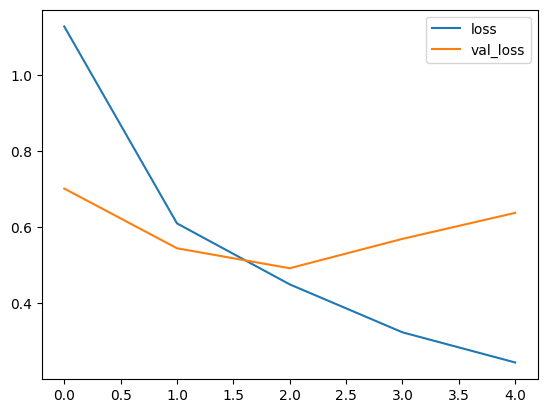

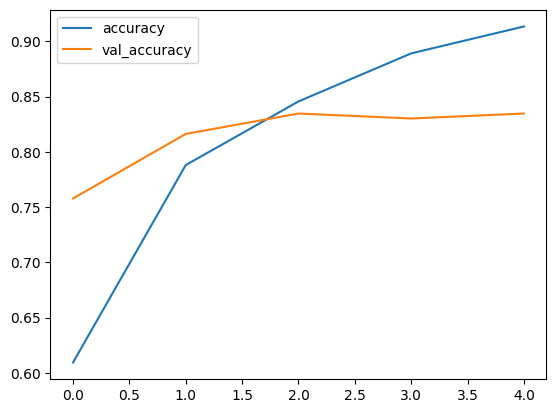

In [70]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['accuracy','val_accuracy']].plot()

In [71]:
result_test = classifier.evaluate(test_ds)

312/312 [==============================] - 14s 45ms/step - loss: 0.6322 - accuracy: 0.8295


## Вторая модель

In [74]:
classifier2 = Sequential()
classifier2.add(Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
classifier2.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=1))
classifier2.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier2.add(Conv2D(filters=25, kernel_size=3,activation='relu', padding='same', strides=1))
classifier2.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier2.add(Conv2D(filters=20, kernel_size=3,activation='relu', padding='same', strides=1))
classifier2.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier2.add(Conv2D(filters=15, kernel_size=3,activation='relu', padding='same', strides=1))
classifier2.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier2.add(Flatten())
classifier2.add(Dense(units=350, activation='relu'))
classifier2.add(Dropout(0.4))
classifier2.add(Dense(units=170, activation='relu'))
classifier2.add(Dropout(0.3))
classifier2.add(Dense(units=40, activation='relu'))
classifier2.add(Dropout(0.2))
classifier2.add(Dense(units=11, activation='softmax'))
classifier2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 25)        7225      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 16, 16, 25)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 20)       

In [75]:
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.01,
                           patience=2),
             ModelCheckpoint('/content/drive/MyDrive/rpsmo_lab2_model/tomato_model2_checkpoint.keras',
                             save_best_only=True)]

In [76]:
history2 = classifier2.fit(train_ds, epochs=50,
                        validation_data = val_ds,
                        callbacks = callbacks)

Epoch 1/50
1723/1723 [==============================] - 155s 89ms/step - loss: 1.8941 - accuracy: 0.3183 - val_loss: 1.4274 - val_accuracy: 0.4828
Epoch 2/50
1723/1723 [==============================] - 155s 90ms/step - loss: 1.3577 - accuracy: 0.5220 - val_loss: 1.0029 - val_accuracy: 0.6465
Epoch 3/50
1723/1723 [==============================] - 150s 87ms/step - loss: 1.0491 - accuracy: 0.6411 - val_loss: 0.8025 - val_accuracy: 0.7094
Epoch 4/50
1723/1723 [==============================] - 150s 87ms/step - loss: 0.8886 - accuracy: 0.6922 - val_loss: 0.7560 - val_accuracy: 0.7324
Epoch 5/50
1723/1723 [==============================] - 150s 87ms/step - loss: 0.8084 - accuracy: 0.7220 - val_loss: 0.6600 - val_accuracy: 0.7664
Epoch 6/50
1723/1723 [==============================] - 151s 88ms/step - loss: 0.7298 - accuracy: 0.7463 - val_loss: 0.5891 - val_accuracy: 0.8008
Epoch 7/50
1723/1723 [==============================] - 156s 91ms/step - loss: 0.6894 - accuracy: 0.7591 - val_loss: 0

In [77]:
classifier2.save('/content/drive/MyDrive/rpsmo_lab2_models/romato_2_model.keras')

<Axes: >

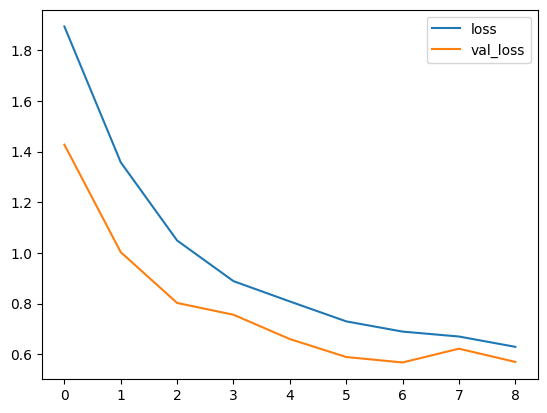

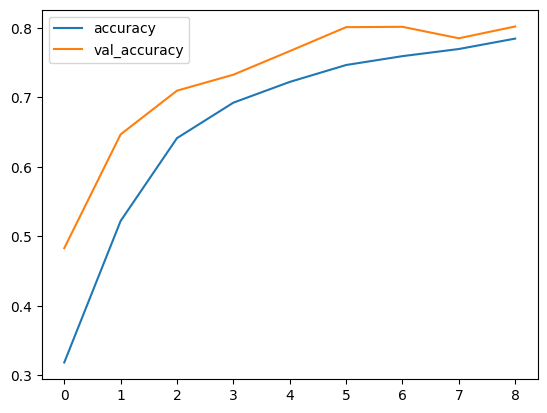

In [78]:
history_frame = pd.DataFrame(history2.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['accuracy','val_accuracy']].plot()

In [79]:
result_test = classifier2.evaluate(test_ds)

312/312 [==============================] - 12s 38ms/step - loss: 0.5765 - accuracy: 0.7951


## Третья модель

In [88]:
classifier3 = Sequential()
classifier3.add(Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
classifier3.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=1))
classifier3.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier3.add(Conv2D(filters=64, kernel_size=3,activation='relu', padding='same', strides=1))
classifier3.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier3.add(Conv2D(filters=64, kernel_size=3,activation='relu', padding='same', strides=1))
classifier3.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier3.add(Conv2D(filters=64, kernel_size=3,activation='relu', padding='same', strides=1))
classifier3.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier3.add(Conv2D(filters=64, kernel_size=3,activation='relu', padding='same', strides=1))
classifier3.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier3.add(Flatten())
classifier3.add(Dense(units=64, activation='relu'))
classifier3.add(Dense(units=11, activation='softmax'))
classifier3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier3.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_64 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 16, 16, 64)      

In [89]:
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.01,
                           patience=2),
             ModelCheckpoint('/content/drive/MyDrive/rpsmo_lab2_model/tomato_model3_checkpoint.keras',
                             save_best_only=True)]

In [90]:
history3 = classifier3.fit(train_ds, epochs=50,
                        validation_data = val_ds,
                        callbacks = callbacks)

Epoch 1/50
1723/1723 [==============================] - 224s 129ms/step - loss: 1.4605 - accuracy: 0.4767 - val_loss: 0.8711 - val_accuracy: 0.6945
Epoch 2/50
1723/1723 [==============================] - 217s 126ms/step - loss: 0.7847 - accuracy: 0.7258 - val_loss: 0.6386 - val_accuracy: 0.7828
Epoch 3/50
1723/1723 [==============================] - 225s 131ms/step - loss: 0.6056 - accuracy: 0.7846 - val_loss: 0.5329 - val_accuracy: 0.8153
Epoch 4/50
1723/1723 [==============================] - 217s 126ms/step - loss: 0.5136 - accuracy: 0.8169 - val_loss: 0.4874 - val_accuracy: 0.8377
Epoch 5/50
1723/1723 [==============================] - 222s 129ms/step - loss: 0.4337 - accuracy: 0.8457 - val_loss: 0.4776 - val_accuracy: 0.8407
Epoch 6/50
1723/1723 [==============================] - 217s 126ms/step - loss: 0.3844 - accuracy: 0.8632 - val_loss: 0.5706 - val_accuracy: 0.8103


In [91]:
classifier3.save('/content/drive/MyDrive/rpsmo_lab2_models/romato_3_model.keras')

<Axes: >

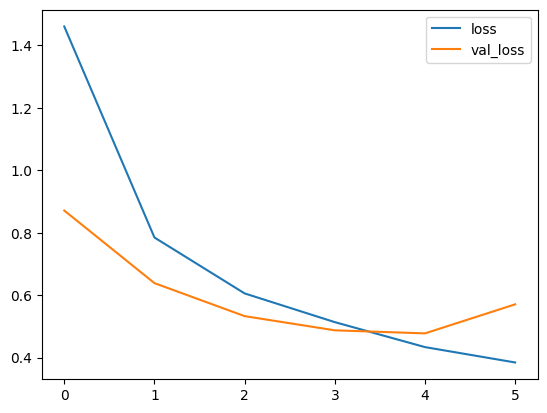

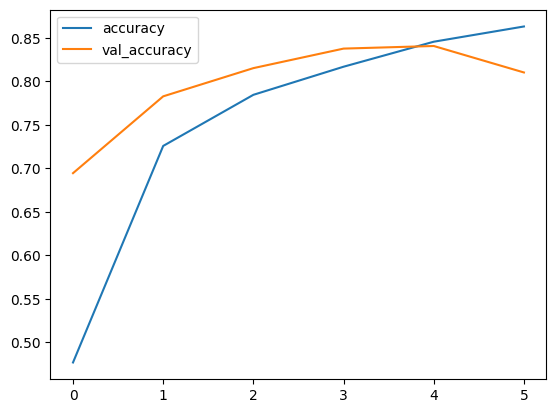

In [92]:
history_frame = pd.DataFrame(history3.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['accuracy','val_accuracy']].plot()

In [99]:
result_test = classifier3.evaluate(test_ds)

312/312 [==============================] - 16s 51ms/step - loss: 0.5867 - accuracy: 0.8426


1/1 [==============================] - 23s 23s/step
Болезнь листа томата : Late_blight 


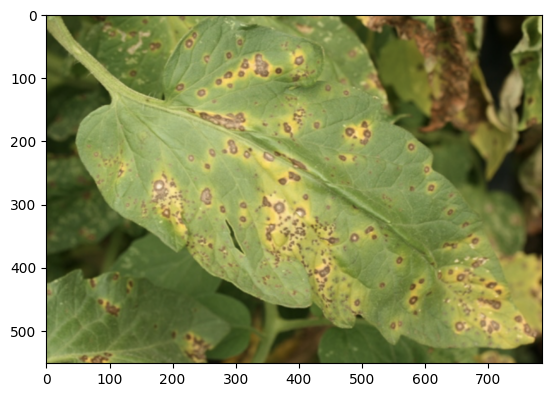

In [109]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
model = load_model('/content/drive/MyDrive/rpsmo_lab2_models/romato_3_model.keras')
# img_path = '/content/drive/MyDrive/rpsmo/tomatoTest/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG'
# img_path = '/content/drive/MyDrive/rpsmo/tomatoTest/005a2c1f-4e15-49e4-9e5c-61dc3ecf9708___RS_Late.B 5096.JPG'
# img_path = '/content/drive/MyDrive/rpsmo/tomatoTest/00bce074-967b-4d50-967a-31fdaa35e688___RS_HL 0223_flipTB.JPG'
# img_path = '/content/drive/MyDrive/rpsmo/tomatoTest/014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_Bact.Sp 2971.JPG'
# img_path = '/content/drive/MyDrive/rpsmo/tomatoTest/01933767-8827-4a46-b089-76b1d8397eb6___YLCV_GCREC 2539.JPG'

img_path = '/content/drive/MyDrive/rpsmo/tomatoTest/late_blight.png'
image = keras.utils.load_img(img_path,target_size=(IMG_SIZE, IMG_SIZE))
input_arr = keras.utils.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)
score = tf.nn.softmax(predictions[0])

pil_image = Image.open(img_path)
imshow(np.asarray(pil_image))
print(
    "Болезнь листа томата : {} "
    .format(class_names[np.argmax(score)])
)